In [1]:
import sys
sys.path.append('..')

import optimus
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import proj3d
import numpy as np
from optimus.source.transducers import transducer_field
from optimus.postprocess.plot import surface_plot

In [2]:
loaded_arr = np.loadtxt("MUSCLE_IPP_abs.txt")

IPP_abs = loaded_arr.reshape(
    loaded_arr.shape[0], loaded_arr.shape[1] // 201, 201)

In [3]:
frequency = 500e3 # 1MHz
a = 0.003 #3cm
D = 0.18 #18 cm
centroid_file='Data/default_random_array_centroid_locations.dat'
source = optimus.source.create_array(frequency, element_radius=a, centroid_locations_filename=centroid_file,
                                     location=[-D, 0, 0], number_of_point_sources_per_wavelength=2, velocity=0.4)

sphere_radius = 7.5e-3
geometry = optimus.geometry.shapes.Sphere(radius=7.5e-3, element_size=0.75e-3)
material_ext = optimus.material.load_material('muscle') #CAMBIE A MUSCULO POR ALPLA MUY BAJO EN WATER
material_int = optimus.material.load_material('bone (cortical)')

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import proj3d

x = source.centroid_locations[0, :]
y = source.centroid_locations[1, :]
z = source.centroid_locations[2, :]


import numpy as np
Nx = 201
Ny = 101
Nz = 101
# Zmax = 0.05 Nz=101 quizas menos
xmin, xmax, ymin, ymax, zmin, zmax = [-D, D, -0.05, 0.05, -0.05, 0.05]

In [4]:
c_0 = material_ext.speed_of_sound #bien
rho_0 = material_ext.density #bien
C_t = material_ext.heat_capacity #/ 1000 #DIVIDIRRRR
k_t = material_ext.thermal_conductivity
eta = material_ext.attenuation_pow_b #attenuation_pow_b
#P = incident_pressure_plot.copy()
alpha_0 = material_ext.attenuation_coeff_a # Np/m
#alpha_0 = material_ext.attenuation_coeff_a * 8.69 # dB/m

In [50]:
k_t

0.49496875000000007

In [5]:
I = (IPP_abs)**2 / (c_0 * rho_0)
alpha = alpha_0 * frequency / 1000000
Q = I.copy()
Q = 2 * alpha * I

In [6]:
delta_x = (xmax - xmin) / Nx
delta_y = (ymax - ymin) / Ny
delta_z = (zmax - zmin) / Nz

## 1. Reducir orden Z

In [7]:
Q = 2 * alpha * I
Q_copy = Q.copy()

bordes_x = 50 #queda de 2*bordes_x+1
bordes_y = 25

Q = [corte[51-bordes_y: 51+bordes_y+1, 101-bordes_x: 101+bordes_x+1] for corte in Q_copy]
Q = Q[51-bordes_y: 51+bordes_y+1]
Q = np.array(Q)

In [8]:
np.shape(Q) #Eje Y y Z son simétricos

(51, 51, 101)

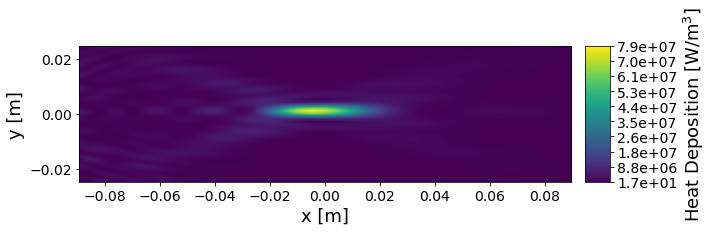

In [9]:
Q_medio = Q[25]
fig = surface_plot(Q_medio,
                   axes_lims=(delta_x * (-bordes_x), delta_x * (bordes_x), 
                              delta_y * (-bordes_y), delta_y * (bordes_y)),
                   axes_labels=("x [m]", "y [m]"),
                   colormap='viridis',
                   colormap_lims=[np.min(Q_medio),np.max(Q_medio)],
                   colorbar_unit="Heat Deposition [W/m$^3$]",
                   )

## 2.Iterar hasta convergencia

In [16]:
Nx = 2 * bordes_x + 1
Ny = 2 * bordes_y + 1
Nz = Ny

t_0 = 37
T_0 = np.zeros_like(Q) + t_0

In [17]:
delta_t = 2e-2
Nt = int(6e4) #4

def get_am(iteracion):
    if iteracion % 200 < 100:
        return 1
    else:
        return 0
    
def next_it_numpy_am(T, Q, am): #am es amortiguador en ese tiempo
    T_ret = np.zeros_like(T) + t_0
    A = 1 - 2 * delta_t * k_t / (rho_0 * C_t) * (delta_x ** (-2) + delta_y ** (-2) + delta_z ** (-2))
    B = delta_t * k_t / (rho_0 * C_t) * (delta_x ** (-2))
    C = delta_t * k_t / (rho_0 * C_t) * (delta_y ** (-2))
    D = delta_t * k_t / (rho_0 * C_t) * (delta_z ** (-2))
    E = delta_t / (rho_0 * C_t)
    T_ret[1:Nz-1, 1:Ny-1, 1:Nx-1] = (Q[1:Nz-1, 1:Ny-1, 1:Nx-1] * E * am +
                             T[1:Nz-1, 1:Ny-1, 1:Nx-1] * A +
                             (T[1:Nz-1, 1:Ny-1, 0:Nx-2] + T[1:Nz-1, 1:Ny-1, 2:Nx]) * B + 
                             (T[1:Nz-1, 0:Ny-2, 1:Nx-1] + T[1:Nz-1, 2:Ny, 1:Nx-1]) * C +
                             (T[0:Nz-2, 1:Ny-1, 1:Nx-1] + T[2:Nz, 1:Ny-1, 1:Nx-1]) * D
                        )
    return T_ret

In [18]:
%%time
temps = []
T_prev = T_0
tiempos = []
for i in range(Nt):
    am = 1
    if i % 100 == 1:
        temps.append(np.max(T_prev))
        tiempos.append(delta_t * i)
    T_prev = next_it_numpy_am(T_prev, Q, am)

CPU times: user 17min 32s, sys: 48.6 ms, total: 17min 32s
Wall time: 17min 32s


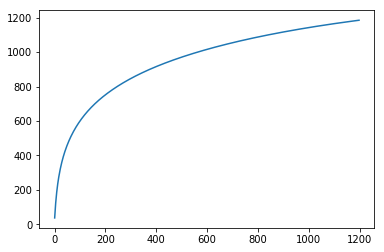

In [19]:
plt.plot(tiempos, temps)

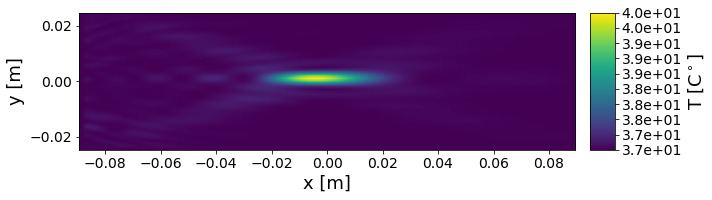

In [54]:
T_medio = T_prev[25]
fig = surface_plot(T_medio,
                   axes_lims=(delta_x * (-bordes_x), delta_x * (bordes_x), 
                              delta_y * (-bordes_y), delta_y * (bordes_y)),
                   axes_labels=("x [m]", "y [m]"),
                   colormap='viridis',
                   colormap_lims=[np.min(T_medio),np.max(T_medio)],
                   colorbar_unit="T [C$^\circ$]",
                   )

## 3.Revisar no apagar Q

In [38]:
delta_t = 2e-5
Nt = int(1.5e4 / 2)

def get_am(iteracion):
    if iteracion % 200 < 100:
        return 1
    else:
        return 0

In [22]:
%%time
temps_am = []
temps_no_am = []
T_prev_am = T_0
T_prev_no_am = T_0
for i in range(Nt):
    am = get_am(i)
    temps_am.append(np.max(T_prev_am))
    temps_no_am.append(np.max(T_prev_no_am))
    T_prev_am = next_it_numpy_am(T_prev_am, Q, am)
    T_prev_no_am = next_it_numpy_am(T_prev_no_am, Q, 1)
    
temps_am.append(np.max(T_prev_am))
temps_no_am.append(np.max(T_prev_no_am))

CPU times: user 4min 22s, sys: 55.9 ms, total: 4min 22s
Wall time: 5min 23s


In [40]:
temps_doble = [2 * (i - 37) + 37 for i in temps_am]

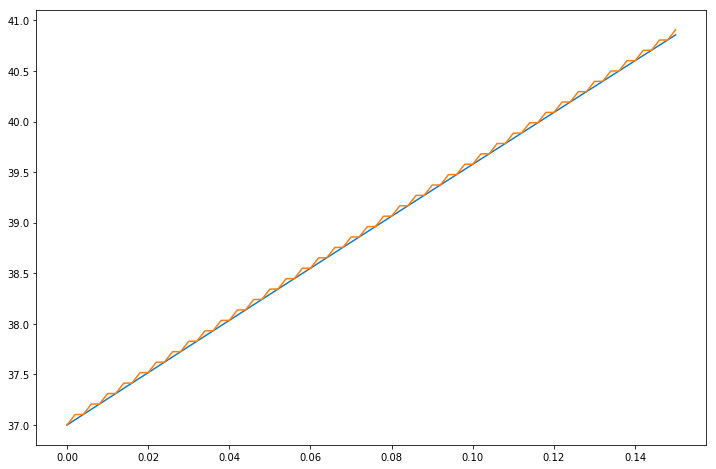

In [42]:
fig = plt.figure(figsize = (12,8))
tiempos = np.arange(Nt + 1) * delta_t 
plt.plot(tiempos, temps_no_am)
plt.plot(tiempos, temps_doble)

In [32]:
37 - temps_no_am[-1]

-3.856563649249807

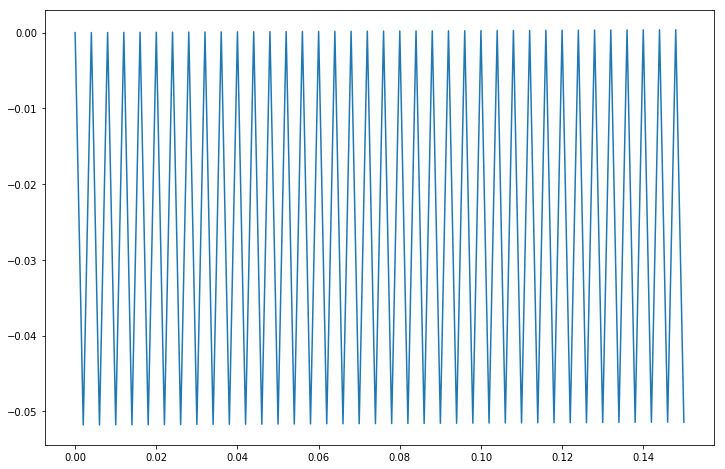

In [47]:
fig = plt.figure(figsize = (12,8))
tiempos = np.arange(Nt + 1) * delta_t 
plt.plot(tiempos, np.array(temps_no_am) - np.array(temps_doble))
#plt.plot(tiempos, temps_doble)

In [34]:
(37 - temps_am[-1]) * 2

-3.9079860361809153

In [49]:
temps_doble[-100]

40.80616981278743

In [48]:
temps_no_am[-100]

40.80603567555866

## 4. Investigar 

Ramping ayuda a mejorar incomodidad al usar las ondas.

## 5.Comparar órdenes

In [24]:
delta_t = 2e-5
Nt = int(1.5e4)
temps = []
T_prev = T_0

In [25]:
%%time
for i in range(Nt):
    am = get_am(i)
    temps.append(np.max(T_prev))
    T_prev = next_it_numpy_am(T_prev, Q, am)
    
temps.append(np.max(T_prev))

CPU times: user 4min 28s, sys: 114 ms, total: 4min 28s
Wall time: 4min 28s


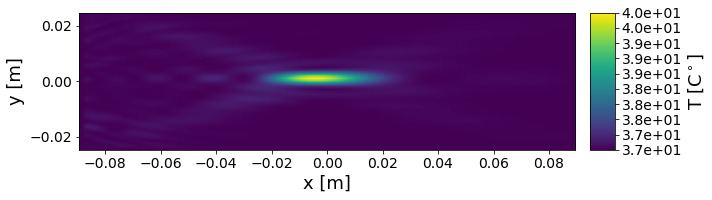

In [26]:
T_medio = T_prev[25]
fig = surface_plot(T_medio,
                   axes_lims=(delta_x * (-bordes_x), delta_x * (bordes_x), 
                              delta_y * (-bordes_y), delta_y * (bordes_y)),
                   axes_labels=("x [m]", "y [m]"),
                   colormap='viridis',
                   colormap_lims=[np.min(T_medio),np.max(T_medio)],
                   colorbar_unit="T [C$^\circ$]",
                   )

Ecuación: $\rho_tC_t\frac{\partial T}{\partial t}=k_t\cdot \nabla^2T+Q$

- $\nabla^2 T\approx \frac{T^t_{x-1,y,z}-2T^t_{x,y,z}+T^t_{x+1,y,z}}{\Delta_x^2}+\frac{T^t_{x,y-1,z}-2T^t_{x,y,z}+T^t_{x,y+1,z}}{\Delta_y^2}+\frac{T^t_{x,y,z-1}-2T^t_{x,y,z}+T^t_{x,y,z+1}}{\Delta_z^2}$

In [27]:
T_ret = np.zeros_like(T_prev) + t_0
A = - 2 * (delta_x ** (-2) + delta_y ** (-2) + delta_z ** (-2))
B = (delta_x ** (-2))
C = (delta_y ** (-2))
D = (delta_z ** (-2))
T_ret[1:Nz-1, 1:Ny-1, 1:Nx-1] = (T_prev[1:Nz-1, 1:Ny-1, 1:Nx-1] * A +
                                (T_prev[1:Nz-1, 1:Ny-1, 0:Nx-2] + T_prev[1:Nz-1, 1:Ny-1, 2:Nx]) * B + 
                                (T_prev[1:Nz-1, 0:Ny-2, 1:Nx-1] + T_prev[1:Nz-1, 2:Ny, 1:Nx-1]) * C +
                                (T_prev[0:Nz-2, 1:Ny-1, 1:Nx-1] + T_prev[2:Nz, 1:Ny-1, 1:Nx-1]) * D)

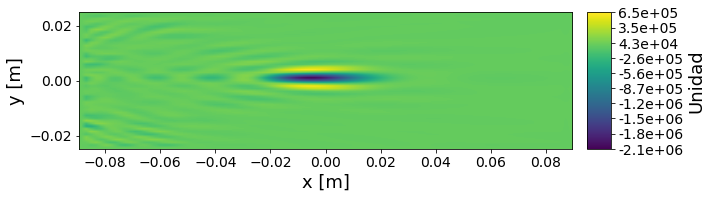

In [28]:
T_medio = T_ret[25]
fig = surface_plot(T_medio,
                   axes_lims=(delta_x * (-bordes_x), delta_x * (bordes_x), 
                              delta_y * (-bordes_y), delta_y * (bordes_y)),
                   axes_labels=("x [m]", "y [m]"),
                   colormap='viridis',
                   colormap_lims=[np.min(T_medio),np.max(T_medio)],
                   colorbar_unit="Unidad",
                   )

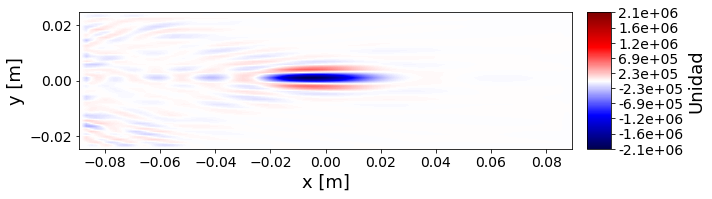

In [53]:
T_medio = T_ret[25]
fig = surface_plot(T_medio,
                   axes_lims=(delta_x * (-bordes_x), delta_x * (bordes_x), 
                              delta_y * (-bordes_y), delta_y * (bordes_y)),
                   axes_labels=("x [m]", "y [m]"),
                   colormap='seismic',
                   colormap_lims=[-np.max(abs(T_medio)),np.max(abs(T_medio))],
                   colorbar_unit="Unidad",
                   )

- Correr (3) más tiempo y revisar los puntos cuando termina un pulso y sacar slicing.
- viridis se usa solo con positivos.
- Realizar última figura para casi equilibrio (la de 20 min), v.
- Ver ramping, probar funciones
- Escribir uncioones con o sin ramping con parámetros como Ramp-duration, etc (cambiar el 100, 200 de get_am).